# Simple Object Detection & Segmentation with CLIP

In [1]:
import os
import requests
from tqdm import tqdm
from matplotlib import pyplot as plt

import jax
import numpy as np
from jax import numpy as jnp, random
import torch
import torchvision
from transformers import FlaxCLIPModel, AutoProcessor, AutoTokenizer

2024-03-12 16:58:27.435920: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Data

In [54]:
def load_img(url):
    img_data = requests.get(url).content
    ftype = url.split('.')[-1]
    with open(f'tmp.{ftype}', 'wb') as f:
        f.write(img_data)
    img = torchvision.io.read_image(f'tmp.{ftype}')
    os.remove(f'tmp.{ftype}')
    
    c, h, w = img.shape
    if c == 1:  # grayscale
        img = img.repeat(3,1,1)
    return img

In [55]:
img = load_img('https://archive.stsci.edu/missions/hst/public/ib48/ib4805010/ib4805010_drz.jpg')

In [56]:
# Make sure img has shape (channels, y_dim, x_dim)!!!
img.shape

torch.Size([3, 962, 1089])

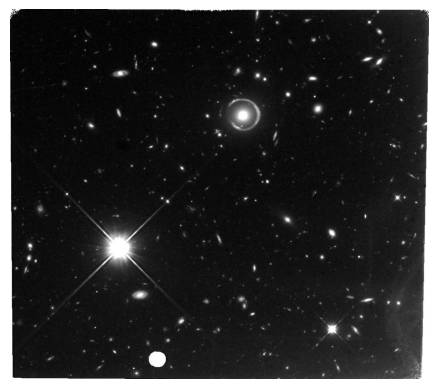

In [57]:
def imshow(img):
    show = img.cpu()
    if img.ndim == 3:
        show = show.permute(1,2,0)
    plt.axis('off')
    plt.margins(0)
    plt.imshow(show)
    plt.show()

imshow(img)

## Window Slices

In [58]:
def make_windows(img: torch.Tensor,
                 y_size: int, y_step: int,
                 x_size: int, x_step: int) -> tuple[torch.Tensor, tuple[slice]]:

    channels, y_dim, x_dim = img.shape

    # Unfold image into shape (channels, n_y, n_x, y_size, x_size)
    unfolded = img.unfold(1, y_size, y_step).unfold(2, x_size, x_step)

    # Permute image into shape (n_y, n_x, channels, y_size, x_size)
    permuted = unfolded.permute(1, 2, 0, 3, 4)

    # Combine (n_y, n_x) into one batch dimension. y-dimension takes precedence.
    batch = permuted.reshape(-1, channels, y_size, x_size)

    # Generate corresponding sequence of slices that represents where each window is extracted from.
    slices = [(slice(y+1-y_size, y+1, None), slice(x+1-x_size, x+1, None))
              for y in range(y_size-1, y_dim, y_step)
              for x in range(x_size-1, x_dim, x_step)]

    return batch, slices

In [59]:
windows, slices = make_windows(img, 256, 128, 128, 64)
windows.shape

torch.Size([96, 3, 256, 128])

Patch 22


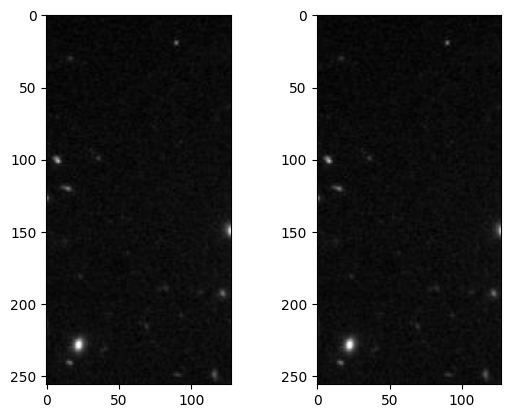

Patch 23


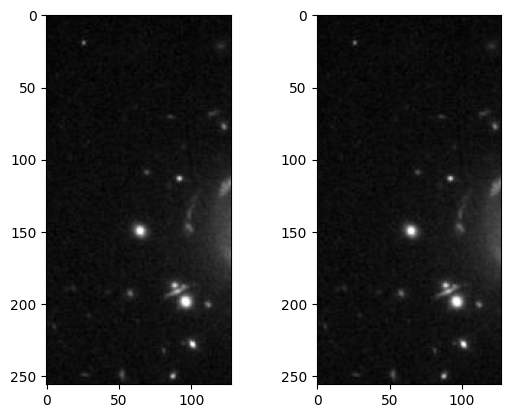

Patch 24


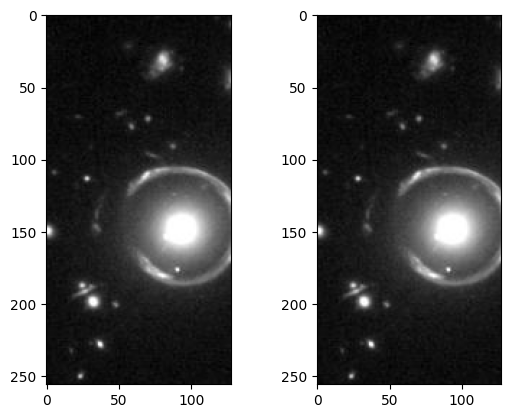

Patch 60


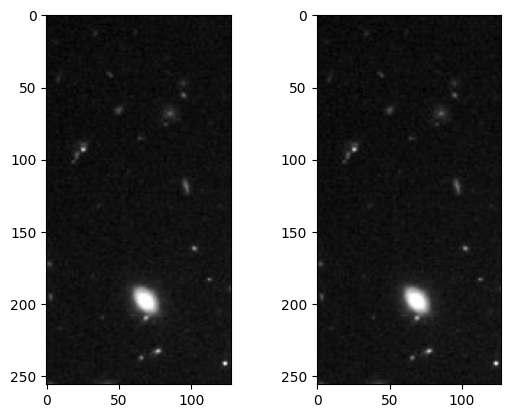

Patch 90


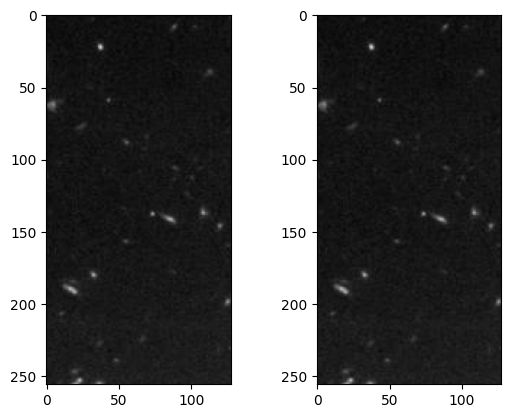

In [60]:
channel_last = img.permute(1,2,0)

for i in (22, 23, 24, 60, 90):
    print(f'Patch {i}')
    f, ax = plt.subplots(1, 2)

    ax[0].imshow(windows[i].permute(1,2,0))
    ax[1].imshow(channel_last[slices[i]])

    plt.show()

## CLIP Heatmap

### Loading the model

In [11]:
model = FlaxCLIPModel.from_pretrained("openai/clip-vit-base-patch16")
processor = AutoProcessor.from_pretrained("openai/clip-vit-base-patch16")
tokenizer = AutoTokenizer.from_pretrained("openai/clip-vit-base-patch16")

2024-03-12 17:02:53.586199: W external/xla/xla/service/gpu/triton_autotuner.cc:646] Compiling 28 configs for triton_gemm_dot.1 on a single thread.


In [12]:
import yaml
from ml_collections.config_dict import ConfigDict

logging_dir = '/n/holystore01/LABS/iaifi_lab/Lab/hubbleclip-checkpoints'
run_name = 'glistening-kumquat-123'

config_file = "{}/{}/config.yaml".format(logging_dir, run_name)

with open(config_file, 'r') as file:
    config = yaml.safe_load(file)
    
config = ConfigDict(config)

In [15]:
import optax 
from flax.training import checkpoints, common_utils, train_state

import flax

replicate = flax.jax_utils.replicate
unreplicate = flax.jax_utils.unreplicate

schedule = optax.warmup_cosine_decay_schedule(
    init_value=0.0,
    peak_value=1e-4,
    warmup_steps=5_000,
    decay_steps=100_000,
)

tx = optax.adamw(learning_rate=schedule, weight_decay=1e-4)
state = train_state.TrainState.create(apply_fn=model.__call__, params=model.params, tx=tx)

# restored_state = state

In [16]:
import orbax.checkpoint as ocp

ckpt_dir = "{}/{}".format(logging_dir, run_name)  # Load SLURM run

best_fn = lambda metrics: metrics[f"val/top_10_accuracy"]

mgr_options = ocp.CheckpointManagerOptions(step_prefix=f'step', best_fn=best_fn, best_mode='min', create=False)

ckpt_mgr_load_ckpt = ocp.CheckpointManager(
    f"{ckpt_dir}/ckpts/",
    options=mgr_options,
)

restored_state = ckpt_mgr_load_ckpt.restore(
    ckpt_mgr_load_ckpt.latest_step(),
    args=ocp.args.StandardRestore(state)
)

if state is restored_state:
    raise FileNotFoundError(f"Did not load checkpoint correctly")

### Segmentation algorithm

In [17]:
def autotune_size_step(y_dim: int,
                       x_dim: int) -> tuple[tuple[int, int],
                                            tuple[int, int]]:
    s_dim = min(y_dim, x_dim)
    l_dim = max(y_dim, x_dim)
    size = l_dim // 6
    step = s_dim // 14
    return ((size, step), (size, step))

In [21]:
def CLIP_segment(img: torch.Tensor,
                 text: str,
                 model: FlaxCLIPModel = model,
                 processor: AutoProcessor = processor,
                 threshold: float = 0.4,
                 temperature: float = 2.0,
                 y_size: int = None, y_step: int = None,
                 x_size: int = None, x_step: int = None,
                 batch_sz: int = 256
                 ) -> jax.Array:

    _, y_dim, x_dim = img.shape

    if y_size is None or y_step is None:
        (y_size, y_step), _ = autotune_size_step(y_dim=y_dim,
                                                 x_dim=x_dim)

    if x_size is None or x_step is None:
        _, (x_size, x_step) = autotune_size_step(y_dim=y_dim,
                                                 x_dim=x_dim)

    windows, slices = make_windows(img,
                                   y_size=y_size, y_step=y_step,
                                   x_size=x_size, x_step=x_step)

    # Calculate scores for each batch of patches
    scores = []
    for batch_start in tqdm(range(0, len(windows), batch_sz)):
        inp = processor(
            images=windows[batch_start:batch_start+batch_sz],
            text=text,
            return_tensors="np",
            padding="max_length",
            truncation=False,
            max_length=77
        )
        out = jax.jit(model)(**inp, params=restored_state.params)
        logits = out.logits_per_image
        scores.append(logits.flatten())
    
    # Remove batch dimensions, concat scores into 1D array
    scores = jnp.concatenate(scores)

    # Rejiggle and softmax
    scores = jax.nn.softmax((scores-scores.mean()) / temperature, axis=-1)
    scores = torch.from_numpy(np.array(scores))

    # Initialise heatmap and frequencies in same shape as img, with 0s everywhere
    heatmap = torch.zeros(img.shape[1:])
    frequency = torch.zeros(img.shape[1:])

    # Update heatmap and frequency
    for score, loc in zip(scores, slices):
        heatmap[loc] += score
        frequency[loc] += 1

    # Average heatmap across CLIP-scores on the same patch,
    # then replace nan (0 frequency) values with 0.0
    heatmap = torch.nan_to_num(heatmap/frequency, nan=0.0)

    # Normalise heatmap to between 0 and 1
    heatmap = heatmap / heatmap.max()

    # Return segmentation mask, heatmap-overlapped visualisation, and heatmap
    return (torch.where(heatmap > threshold, 1, 0),
            (heatmap * img).to(dtype=torch.uint8),
            heatmap)

In [61]:
mask, vis, heatmap = CLIP_segment(img, "strong lensing")

100%|██████████| 1/1 [00:45<00:00, 45.01s/it]


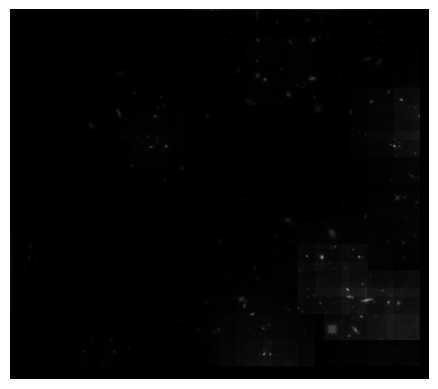

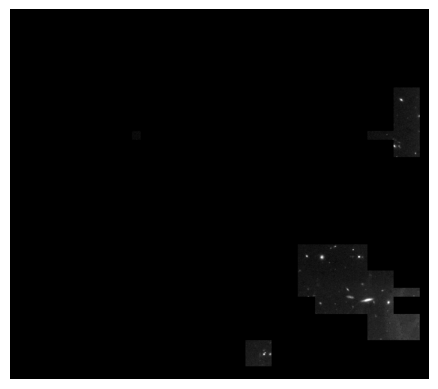

In [62]:
imshow(vis)
imshow(mask.cpu()*img)

## Fun

In [ ]:
url = input("Enter image URL: ")
text = input("Enter text: ").strip()

test_img = load_img(url)
mask, vis, heatmap = CLIP_segment(test_img, text, threshold=0.4)
imshow(vis)
imshow(mask.cpu()*test_img)

In [ ]:
url = input("Enter image URL: ")
text = input("Enter text: ").strip()

test_img = load_img(url)
mask, vis, heatmap = CLIP_segment(test_img, text)
imshow(vis)
imshow(mask.cpu()*test_img)